# Setup

In [ ]:
cluster.close(); client.close()

In [ ]:
%load_ext autoreload
# %autoreload 2

%matplotlib inline

import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seawater as sw
%aimport xarray
import xarray as xr

# import hvplot.xarray

%aimport dcpy
%aimport pump

# import facetgrid

mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.dpi"] = 120

xr.set_options(keep_attrs=False)

import distributed
import dask_jobqueue
          
from distributed import performance_report

print(dask.__version__)
print(distributed.__version__)
print(xr.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.9.1
2.9.1
0.14.0+145.ga834dde4


## Local cluster

In [ ]:
cluster = distributed.LocalCluster(threads_per_worker=1, n_workers=6)
cluster

In [ ]:
cluster.close()

## distributed cluster

In [ ]:
import ncar_jobqueue

cluster.close()
cluster = ncar_jobqueue.NCARCluster(project="ncgd0011", cores=9, dashboard_address=":9999", processes=9)
cluster

In [ ]:
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q regular
#PBS -A ncgd0011
#PBS -l select=1:ncpus=36:mem=109GB
#PBS -l walltime=01:00:00
#PBS -e /glade/scratch/dcherian/
#PBS -o /glade/scratch/dcherian/
JOB_ID=${PBS_JOBID%%.*}

/glade/u/home/dcherian/miniconda3/envs/dcpy_updated/bin/python -m distributed.cli.dask_worker tcp://10.148.10.55:35571 --nthreads 1 --nprocs 9 --memory-limit 12.11GB --name name --nanny --death-timeout 60 --local-directory None --interface ib0



In [ ]:
cluster.scale(9*4)

In [ ]:
cluster.close()

# Read data

In [ ]:
client = distributed.Client(cluster)
client

<Client: 'tcp://127.0.0.1:46271' processes=6 threads=6, memory=117.04 GB>

In [ ]:
gcm1 = pump.model(
    "../glade/TPOS_MITgcm_1_hb/HOLD_NC_LINKS/", name="gcm1", full=True, budget=True,
)
# gcm1.tao.load()
# gcm1.tao = xr.merge([gcm1.tao, pump.calc.get_tiw_phase(gcm1.tao.v)])
#gcm1.surface["zeta"] = xr.open_dataset(
#    gcm1.dirname + "obs_subset/surface_zeta.nc"
#).zeta

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:46304 remote=tcp://127.0.0.1:46271>


Reading all files took 117.20933985710144 seconds


In [ ]:
mld = pump.calc.get_mld(gcm1.full.dens.sel(depth=slice(-200)))

In [ ]:
full_ds = (
    xr.merge([
        gcm1.surface.theta,
        gcm1.budget.Jq.sel(time=gcm1.surface.time.values, depth=slice(-150)).chunk({"depth": -1}),
        mld.sel(time=gcm1.surface.time.values),
    ])
    .rename({"theta": "sst"})
    .chunk({"time": 1, "latitude": -1, "longitude": -1})
)
full_ds

<xarray.Dataset>
Dimensions:    (depth: 150, latitude: 480, longitude: 1500, time: 2947)
Coordinates:
  * latitude   (latitude) float32 -12.0 -11.949896 -11.899791 ... 11.949896 12.0
  * depth      (depth) float64 -0.5 -1.5 -2.5 -3.5 ... -147.5 -148.5 -149.5
  * longitude  (longitude) float32 -170.0 -169.94997 ... -95.05003 -95.0
  * time       (time) datetime64[ns] 1995-09-01 ... 1997-01-04T12:00:00
Data variables:
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(1, 480, 1500), meta=np.ndarray>
    Jq         (time, depth, latitude, longitude) float64 dask.array<chunksize=(1, 150, 480, 1500), meta=np.ndarray>
    mld        (time, latitude, longitude) float32 dask.array<chunksize=(1, 480, 1500), meta=np.ndarray>

In [ ]:
ijq = (
    transform_jq(gcm1.budget.Jq, mld)
    .isel(time=slice(0, 120*6, 120))
    .load()
)

In [ ]:
sst = gcm1.surface.theta.isel(time=slice(0, 120*6, 120)).load()
sst.name = "sst"

In [ ]:
ds = xr.merge([sst, ijq]) #.isel(time=slice(0, 120*6, 120))

In [ ]:
import pandas as pd
import cartopy.crs as ccrs

import matplotlib.pyplot as plt
import colorcet


def clean_axis(ax):
    ax.tick_params(
        axis="both", direction="in", color='k', top=True, right=True, length=7.5, width=1,
    )
    ax.set_yticks([-10, -5, 0, 5, 10])

    ylabels = []
    for tt in ax.get_yticks():
        if tt < 0:
            add = "S"
        elif tt > 0:
            add = "N"
        else:
            add = ""
        ylabels.append(str(tt) + "°" + add)
    ax.set_yticklabels(ylabels)

    ax.set_xticks([-95, -110, -125, -140, -155, -170])
    ax.set_xticklabels([str(tt)[1:]+"°W" for tt in ax.get_xticks()])
    for spine in ax.spines:
        ax.spines[spine].set_color("k")
        

def render(ds, suffix="", save=False):
        
    if ds.sizes["time"] == 0:
        return ds["time"]
    
    time = ds.time
    ds = ds.sel(latitude=slice(-10, 10)).squeeze()

    plt.style.use("dark_background")
    plt.rcParams["font.family"] = "monospace"
    plt.rcParams["font.size"] = 17
    
    cbar_kwargs = dict(
        aspect=30, 
        shrink=0.75,
        fraction=0.1,
        pad=0.001,
        # orientation="horizontal",        
        # spacing="proportional",
    )

    f, axx = plt.subplots(2, 1, constrained_layout=True)
    
    f.set_constrained_layout_pads(
        w_pad=0/72., h_pad=1/72., hspace=0, wspace=0
    )


    ax = axx[0]
    handle = ds.sst.plot(
        ax=ax,
        # cmap=colorcet.cm.bkr,
        cmap=mpl.cm.RdYlBu_r,
        # cmap=mpl.cm.Blues_r,
        add_labels=False,
        add_colorbar=False,
        vmin=21,
        vmax=28.5,
    )
    
    # cax = plt.axes(
    #    [0.075, 0.62, 0.2, 0.05],
    #    facecolor='w',
    #    # facealpha=0.1,
    #)
    cb = f.colorbar(
        handle, 
        ax=[ax],
        label="", #"Sea Surface Temperature SST [°C]",
        extend="both",
        **cbar_kwargs
    )
    cb.outline.set_visible(False)
    
    ax.text(0.025, 0.05, 
            "SST [°C]", 
            color='w',
            transform=ax.transAxes)


    ax = axx[1]
    handle = ds.Jq.plot(
        ax=ax,
        # levels=np.sort([0, -20, -30, -40, -50, -60, -100, -150]),
        # robust=True,
        #cmap=mpl.cm.magma_r,
        #norm=mpl.colors.LogNorm(1e-5, 5e-3),
        vmax=0, 
        vmin=-150,
        cmap=colorcet.cm.CET_L17_r,
        # cmap=colorcet.cm.fire_r,
        # cmap=colorcet.cm.CET_CBL2_r, 
        # cmap=colorcet.cm.kbc_r,
        add_labels=False, 
        # transform=ccrs.PlateCarree(),
        # cbar_kwargs={"orientation": "horizontal"}
        add_colorbar=False,
    )

    cb = f.colorbar(handle, 
                    ax=[ax], 
                    extend="both", 
                    label='',
                    **cbar_kwargs,
                   )
    cb.outline.set_visible(False)

    # ax.set_aspect(1.5)
    # ax.axis("off")
    ax.text(0.99, 0.08, 
            str(ds.time.dt.strftime("%Y-%h-%d %H:%M").values)
            + "\nMITgcm 1/20°, 1m Δz", 
            color='k',
            ha="right",
            transform=ax.transAxes)
    if suffix == "":
        extra = "\nbelow mixed layer "
    else:
        extra = "\n"
    ax.text(0.025, 0.08, 
            f"0-150m mean KPP vertical heat flux {extra}[W/m²]", 
            color='k',
            transform=ax.transAxes)
   # ax.text(0.25, 0.05, , transform=ax.transAxes)

    [clean_axis(ax) for ax in axx]
    [tt.set_visible(False) for tt in axx[0].get_xticklabels()]

    #labels = [str(int(tt)) + " W/m²" for tt in cb.ax.get_xticks()]
    #labels[-1] = "0"
    # cb.ax.set_xticklabels(labels)

    # ax.xaxis.set_major_formatter(LongitudeFormatter())
    # ax.set_facecolor("k")
    f.set_size_inches((16/9*7.5, 7.5))
    f.canvas.draw()
    f.canvas.draw()
    
    if save:
        f.savefig(
            f"/glade/u/home/dcherian/pump/glade/movies/sst_jq/{ds.time.dt.strftime('%Y-%m-%d-%H').values}{suffix}.png",
            dpi=200, 
            # bbox_inches="tight"
        )
    return time


def transform_jq(jq, mld=None):
    """ 
    Depth integrate diffusive heat flux in top 150m below mixed layer
    """

    j = jq.rolling(depth=2, center=True, min_periods=1).mean()
    if mld is not None:
        j = j.where(j.depth < (mld - 5)).sel(depth=slice(-150))

    j = j.where(j < 0).sum("depth") / 150
    j.name = "Jq"
    return j


def render_both(ds, save=False):
    
    if ds.sizes["time"] == 0:
        return ds.time

    if ds.time.squeeze().values < pd.to_datetime("1995-11-01"):
        dsnew = xr.merge([
            ds.sst,
            transform_jq(ds.Jq)
        ])
   
    else:
        dsnew = xr.merge([
            ds.sst,
            transform_jq(ds.Jq, ds.mld)
        ])
        
    render(dsnew, suffix="", save=save)
    
    return ds.time

In [ ]:
sub = full_ds.isel(time=[6]).compute()

NameError: name 'full_ds' is not defined

In [ ]:
full_ds.isel(time=[9]).map_blocks(render_both, kwargs=dict(save=False)).compute()

<xarray.DataArray 'time' (time: 1)>
array(['1995-09-02T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1995-09-02T12:00:00
Attributes:
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    axis:                 T
    _CoordinateAxisType:  Time

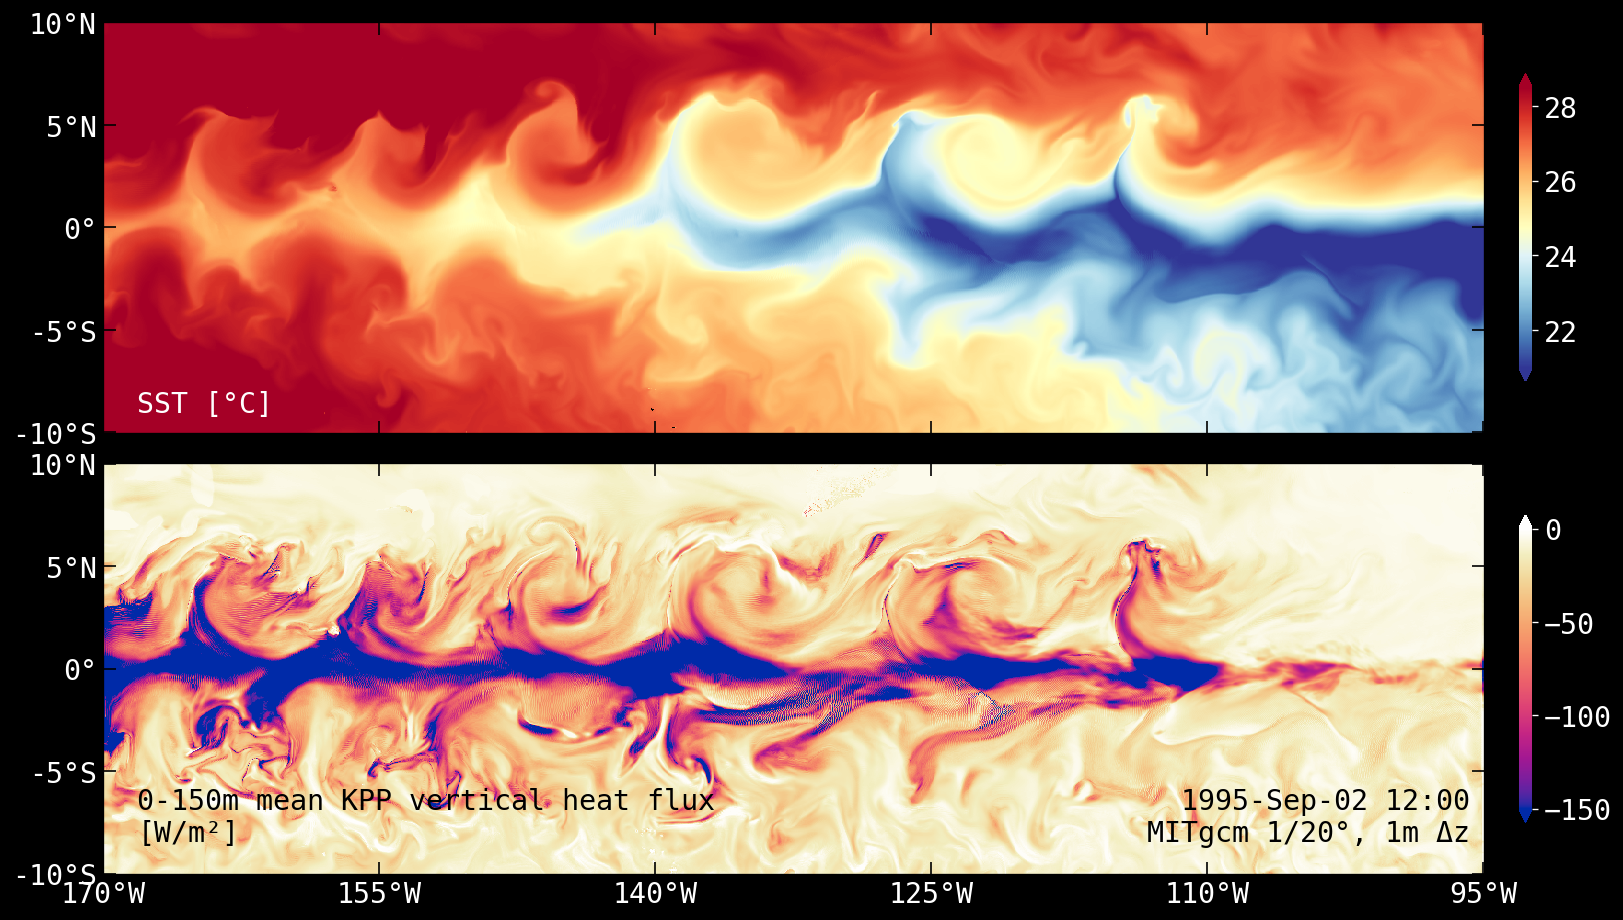

In [ ]:
render_both(full_ds.isel(time=[9]), save=False)

<xarray.DataArray 'time' (time: 1)>
array(['1995-09-02T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1995-09-02T12:00:00
Attributes:
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    axis:                 T
    _CoordinateAxisType:  Time

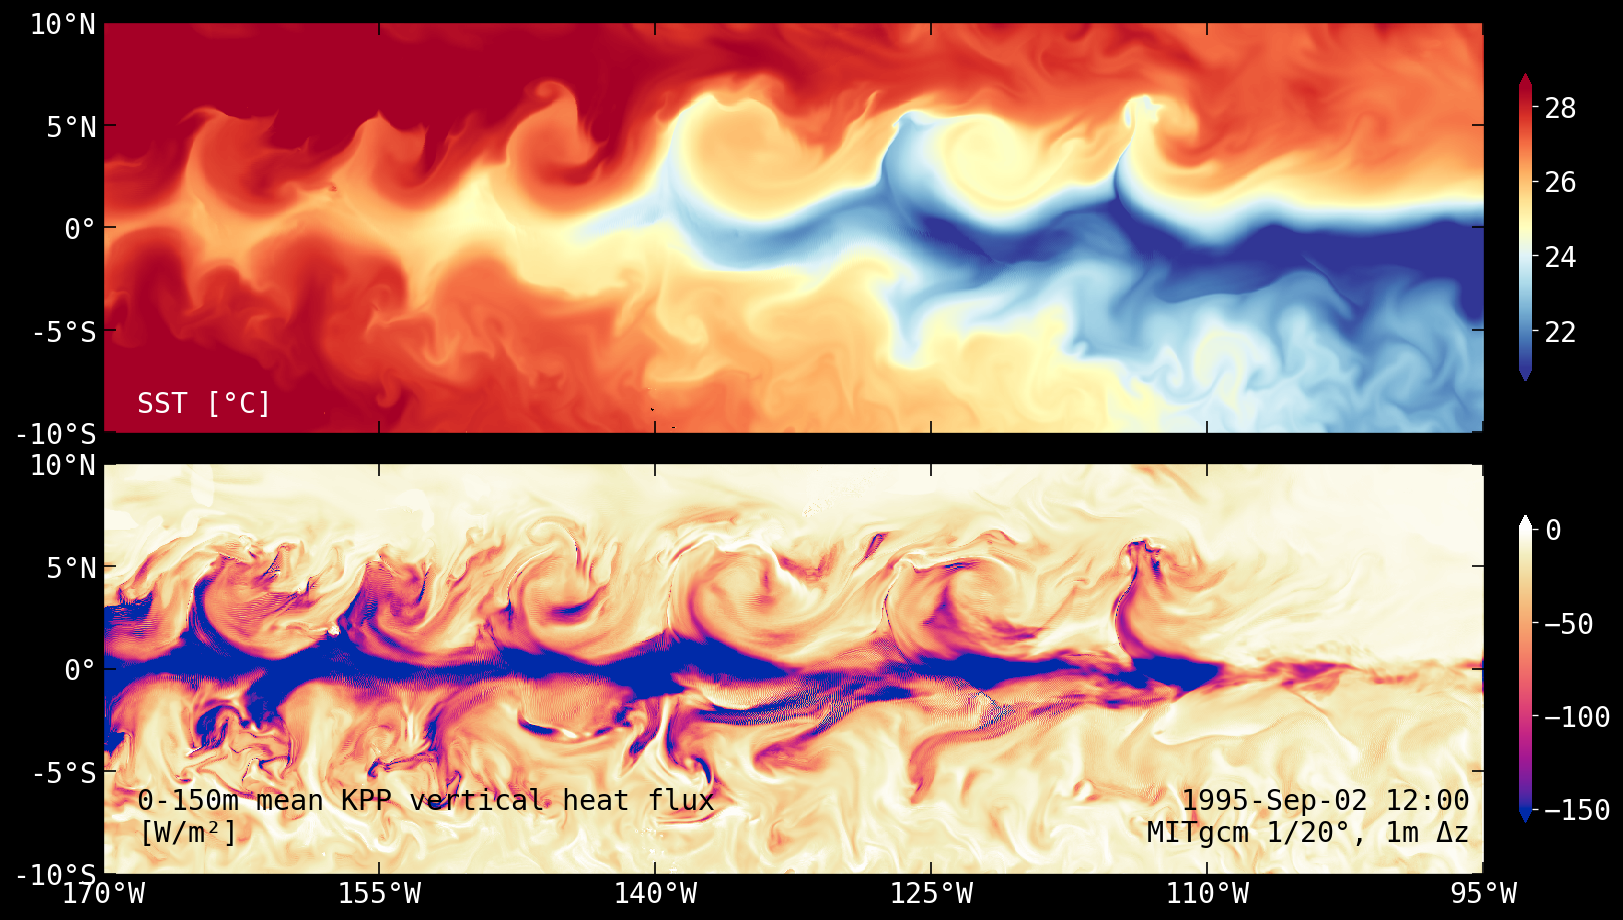

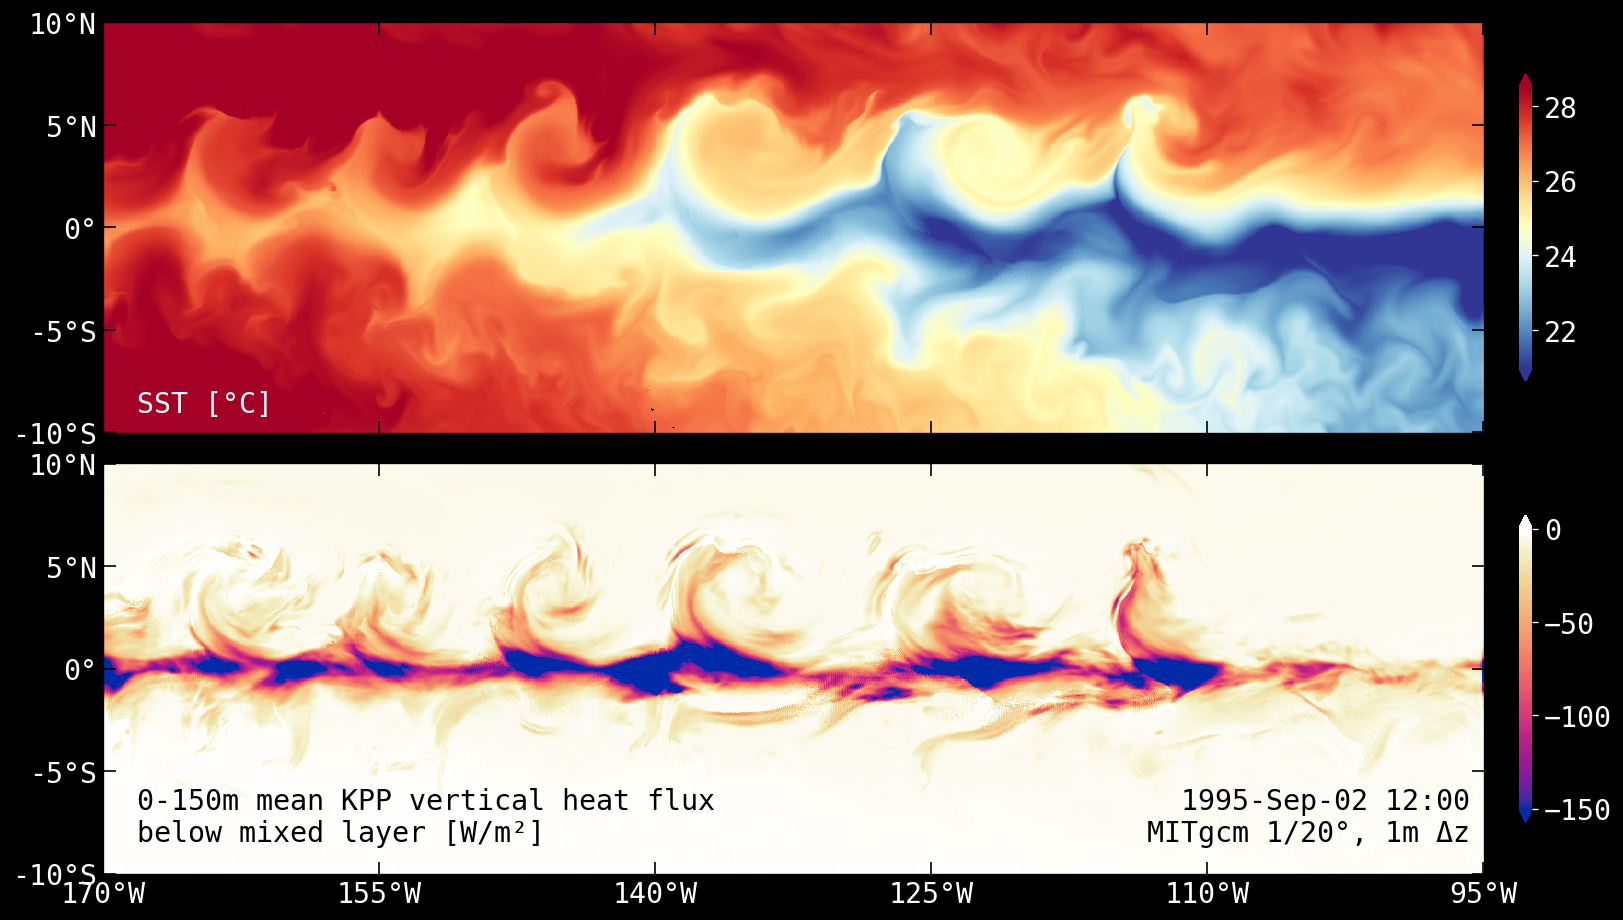

In [ ]:
%matplotlib inline

render_both(full_ds.isel(time=[9]), save=False)

# previous versions

<xarray.DataArray 'time' (time: 1)>
array(['1995-09-21T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    depth    float32 -0.5
  * time     (time) datetime64[ns] 1995-09-21
Attributes:
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    axis:                 T
    _CoordinateAxisType:  Time

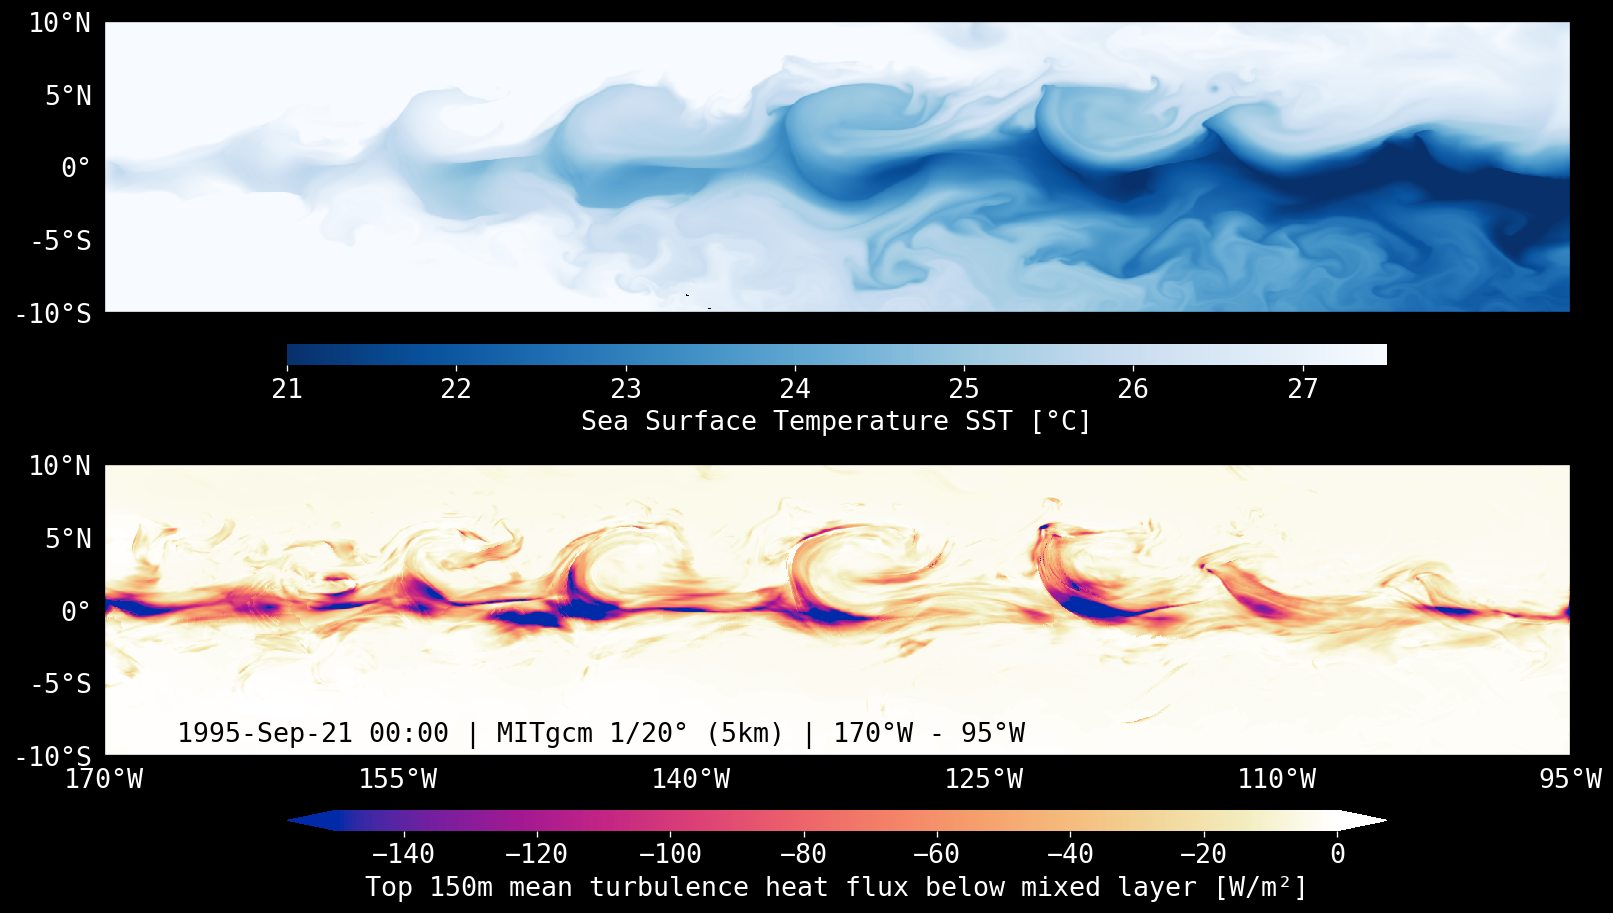

In [ ]:
%matplotlib inline

render(ds.isel(time=[1]))

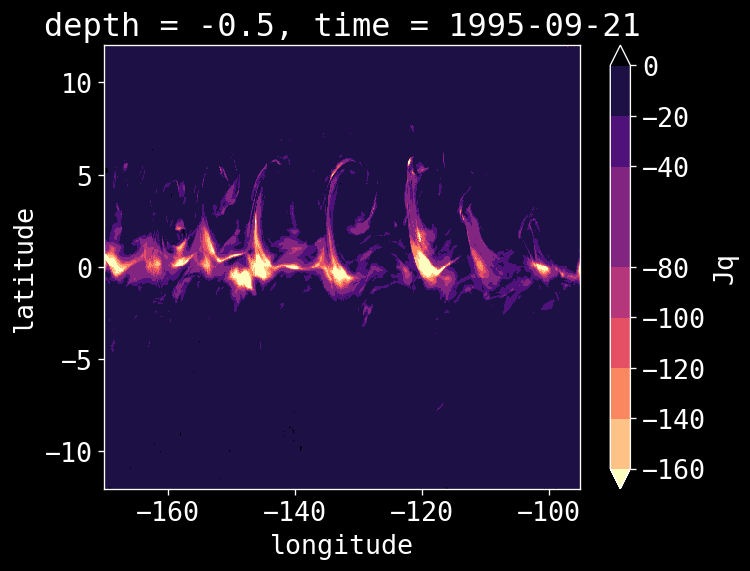

In [ ]:
ds.isel(time=1).Jq.plot(levels=[-160, -140, -120, -100, -80, -40, -20, 0],
                        cmap=mpl.cm.magma_r,
                        cbar_kwargs={"spacing": "proportional"})

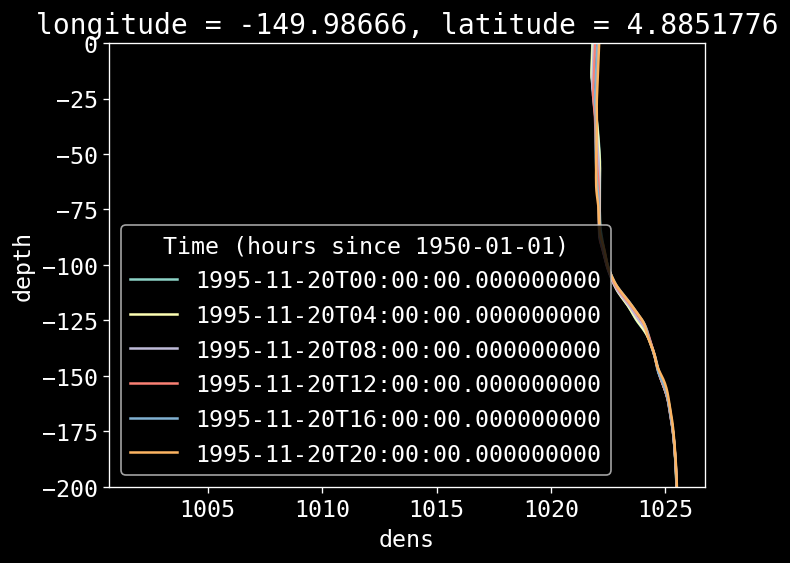

In [ ]:
(
    gcm1.full.dens.sel(time="1995-11-20", latitude=4.9, longitude=-150, method="nearest")
    .plot.line(hue="time", y="depth", ylim=(-200, 0))
)

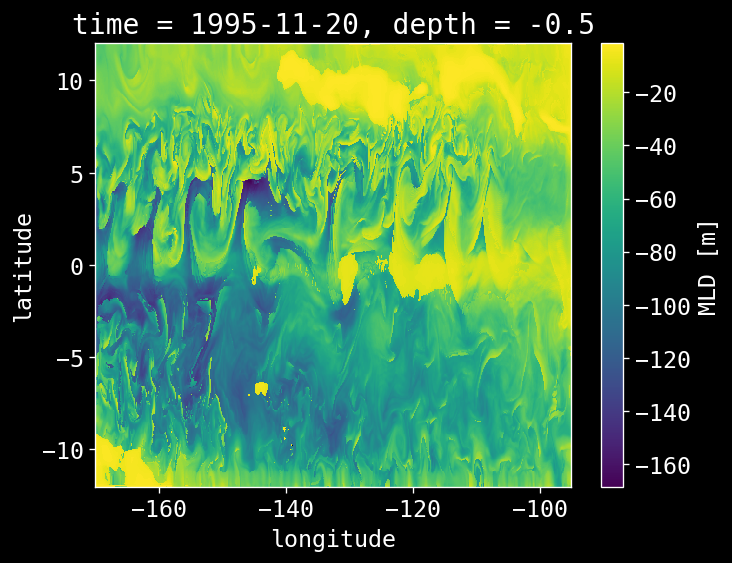

In [ ]:
mld.sel(time=ds.isel(time=4).time).plot()

<xarray.DataArray 'time' (time: 1)>
array(['1995-10-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    depth    float32 -0.5
  * time     (time) datetime64[ns] 1995-10-31
Attributes:
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    axis:                 T
    _CoordinateAxisType:  Time

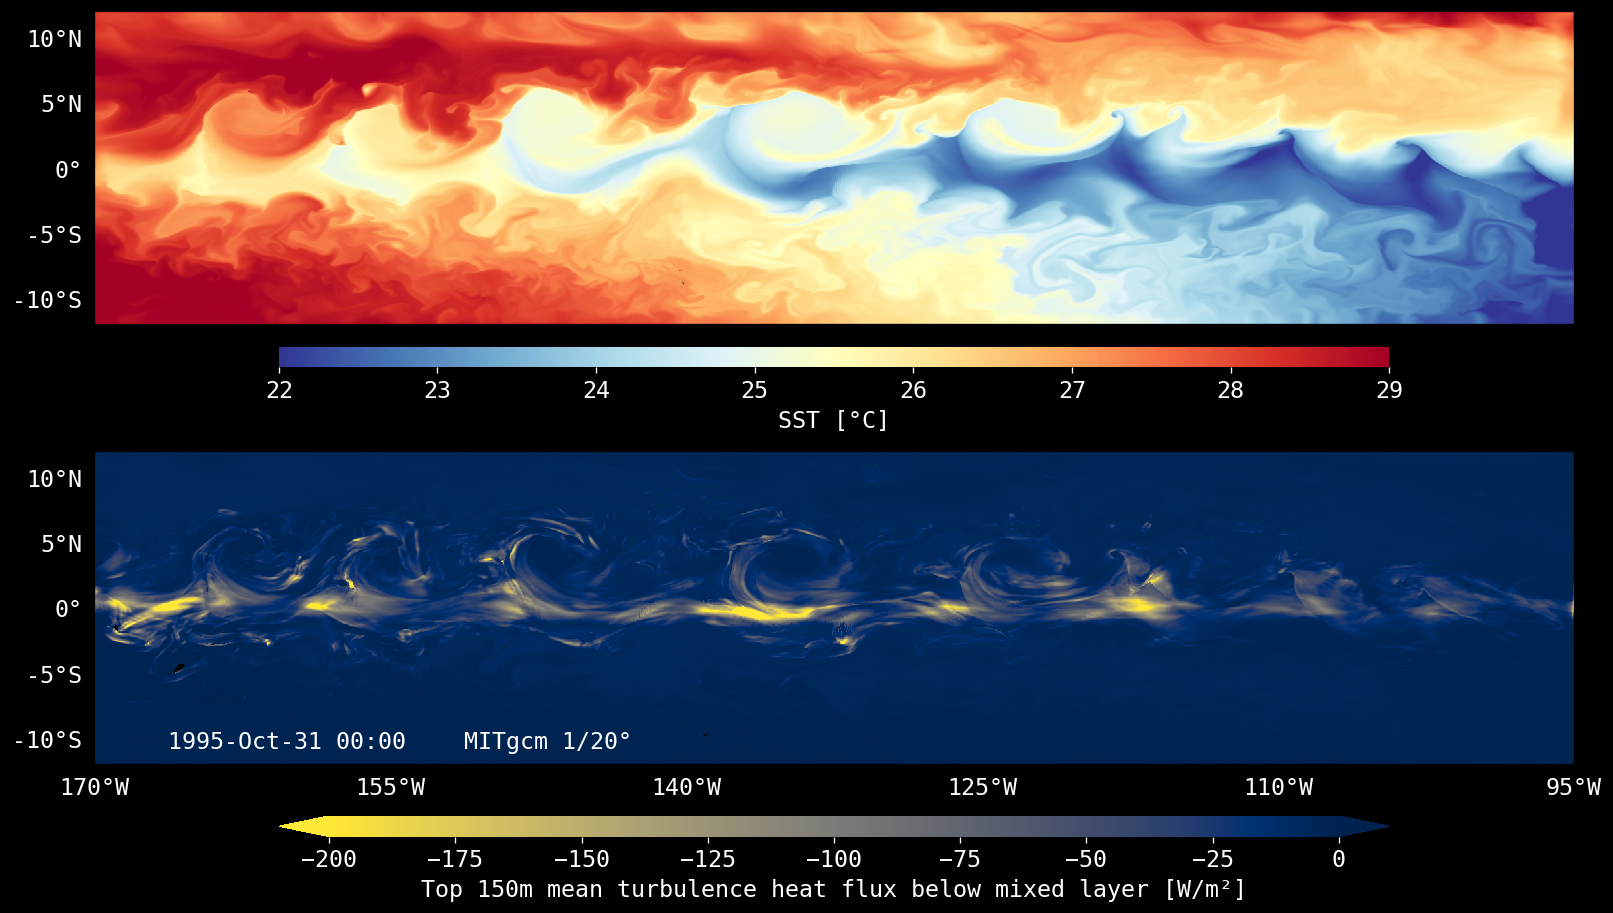

In [ ]:
render(ds.isel(time=[3]))

<xarray.DataArray 'time' (time: 1)>
array(['1995-10-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    depth    float32 -0.5
  * time     (time) datetime64[ns] 1995-10-31
Attributes:
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    axis:                 T
    _CoordinateAxisType:  Time

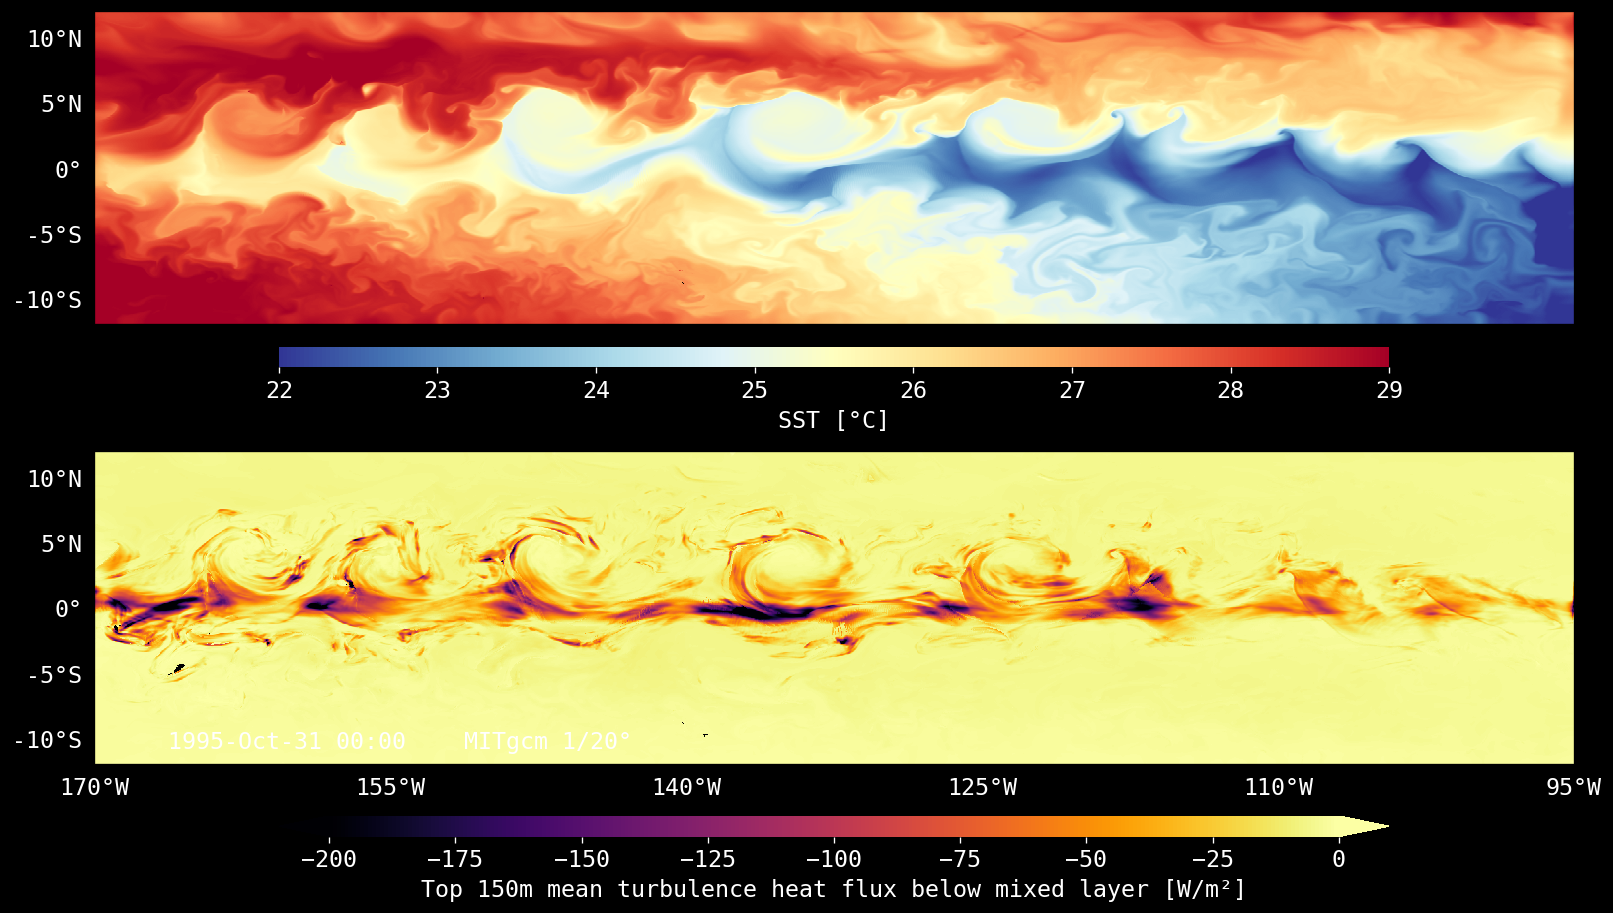

In [ ]:
render(ds.isel(time=[3]))

<xarray.DataArray 'time' (time: 1)>
array(['1997-01-04T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    depth    float32 -0.5
  * time     (time) datetime64[ns] 1997-01-04T12:00:00
Attributes:
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    axis:                 T
    _CoordinateAxisType:  Time

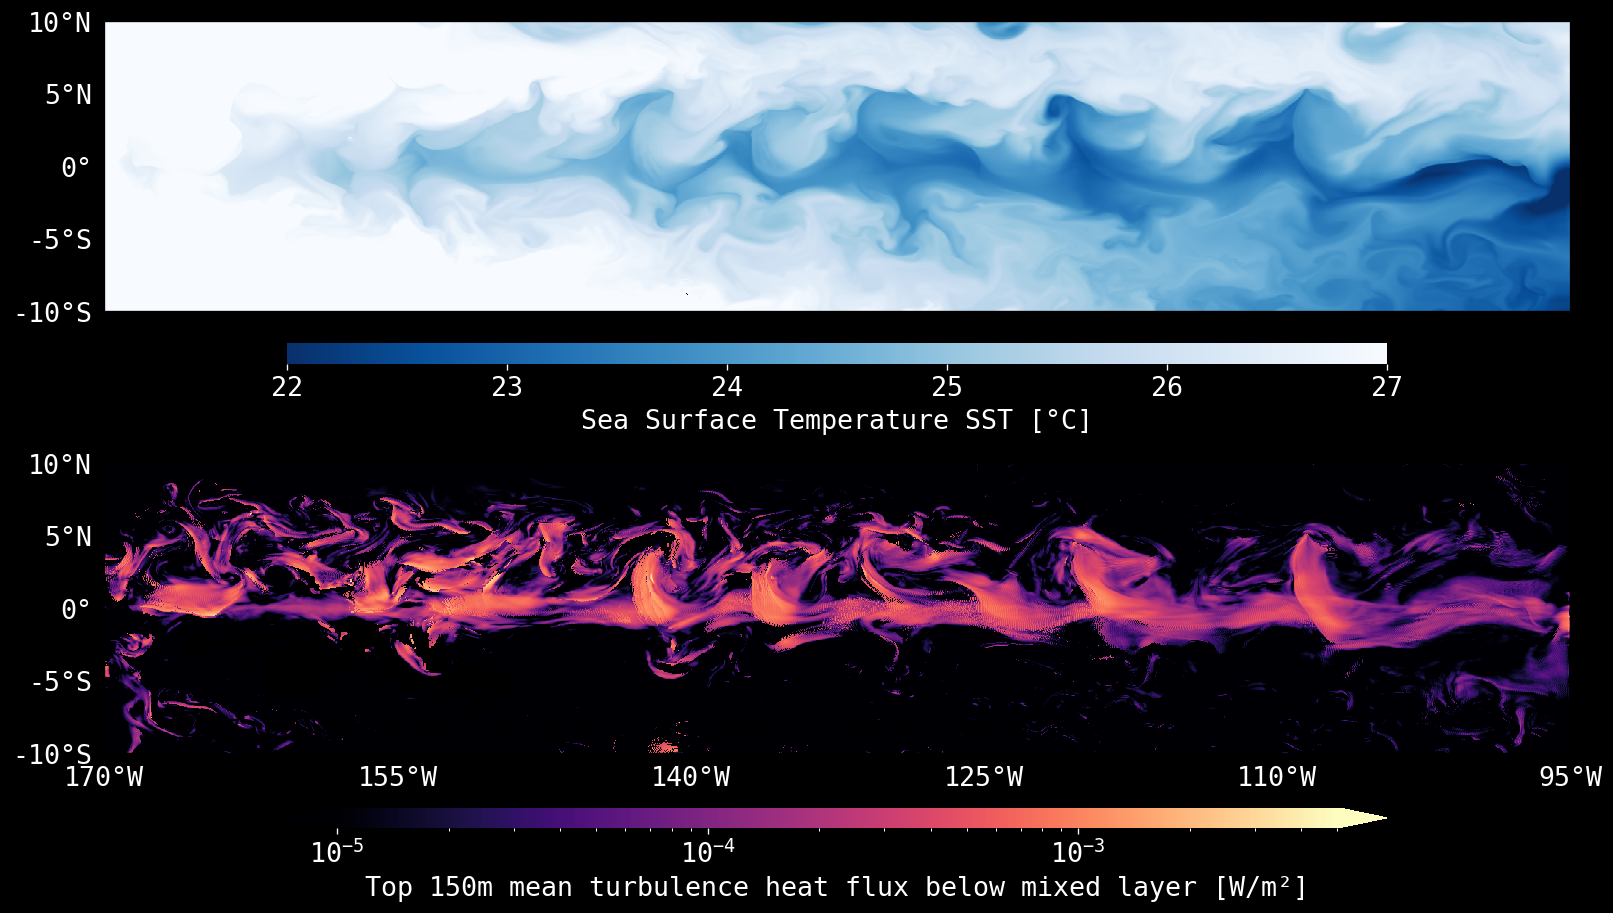

In [ ]:
render(full_ds.isel(time=[-1]))

In [ ]:
sub = (
    gcm1.budget.Jq
    .sel(longitude=-110, method="nearest", latitude=2)
    .isel(time=slice(100), depth=slice(250))
).load()

In [ ]:
submld = (
    mld.sel(longitude=-110, method="nearest", latitude=2)
    .isel(time=slice(100))
).load()

In [ ]:
(full_ds.Jq
 .sel(longitude=-110, method="nearest", latitude=2)
 .isel(time=slice(90, 100))
).plot()

# full render

In [ ]:
mapped = full_ds.sel(time=slice("01-Dec-1995")).map_blocks(render_both, kwargs={"save": True})
mapped

<xarray.DataArray 'time' (time: 552)>
dask.array<render_both-1fa9b4af8dddac42dae39bd41eb4888a-<this, shape=(552,), dtype=datetime64[ns], chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1995-09-01 ... 1995-12-01T20:00:00
Attributes:
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    axis:                 T
    _CoordinateAxisType:  Time

In [ ]:
mapped.isel(time=[0]).compute()

<xarray.DataArray 'time' (time: 1)>
array(['1995-09-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1995-09-01
Attributes:
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    axis:                 T
    _CoordinateAxisType:  Time

In [ ]:
dcpy.dask.batch_load(mapped.isel(time=slice(120+160+100,None)), factor=20)

computing {'time': slice(0, 20, None)}
computing {'time': slice(20, 40, None)}
computing {'time': slice(40, 60, None)}
computing {'time': slice(60, 80, None)}
computing {'time': slice(80, 100, None)}
computing {'time': slice(100, 120, None)}
computing {'time': slice(120, 140, None)}
computing {'time': slice(140, 160, None)}
computing {'time': slice(160, 180, None)}


<xarray.DataArray 'time' (time: 172)>
array(['1995-11-03T08:00:00.000000000', '1995-11-03T12:00:00.000000000',
       '1995-11-03T16:00:00.000000000', '1995-11-03T20:00:00.000000000',
       '1995-11-04T00:00:00.000000000', '1995-11-04T04:00:00.000000000',
       '1995-11-04T08:00:00.000000000', '1995-11-04T12:00:00.000000000',
       '1995-11-04T16:00:00.000000000', '1995-11-04T20:00:00.000000000',
       '1995-11-05T00:00:00.000000000', '1995-11-05T04:00:00.000000000',
       '1995-11-05T08:00:00.000000000', '1995-11-05T12:00:00.000000000',
       '1995-11-05T16:00:00.000000000', '1995-11-05T20:00:00.000000000',
       '1995-11-06T00:00:00.000000000', '1995-11-06T04:00:00.000000000',
       '1995-11-06T08:00:00.000000000', '1995-11-06T12:00:00.000000000',
       '1995-11-06T16:00:00.000000000', '1995-11-06T20:00:00.000000000',
       '1995-11-07T00:00:00.000000000', '1995-11-07T04:00:00.000000000',
       '1995-11-07T08:00:00.000000000', '1995-11-07T12:00:00.000000000',
       '1995-11-07T16:00:00.000000000', '1995-11-07T20:00:00.000000000',
       '1995-11-08T00:00:00.000000000', '1995-11-08T04:00:00.000000000',
       '1995-11-08T08:00:00.000000000', '1995-11-08T12:00:00.000000000',
       '1995-11-08T16:00:00.000000000', '1995-11-08T20:00:00.000000000',
       '1995-11-09T00:00:00.000000000', '1995-11-09T04:00:00.000000000',
       '1995-11-09T08:00:00.000000000', '1995-11-09T12:00:00.000000000',
       '1995-11-09T16:00:00.000000000', '1995-11-09T20:00:00.000000000',
       '1995-11-10T00:00:00.000000000', '1995-11-10T04:00:00.000000000',
       '1995-11-10T08:00:00.000000000', '1995-11-10T12:00:00.000000000',
       '1995-11-10T16:00:00.000000000', '1995-11-10T20:00:00.000000000',
       '1995-11-11T00:00:00.000000000', '1995-11-11T04:00:00.000000000',
       '1995-11-11T08:00:00.000000000', '1995-11-11T12:00:00.000000000',
       '1995-11-11T16:00:00.000000000', '1995-11-11T20:00:00.000000000',
       '1995-11-12T00:00:00.000000000', '1995-11-12T04:00:00.000000000',
       '1995-11-12T08:00:00.000000000', '1995-11-12T12:00:00.000000000',
       '1995-11-12T16:00:00.000000000', '1995-11-12T20:00:00.000000000',
       '1995-11-13T00:00:00.000000000', '1995-11-13T04:00:00.000000000',
       '1995-11-13T08:00:00.000000000', '1995-11-13T12:00:00.000000000',
       '1995-11-13T16:00:00.000000000', '1995-11-13T20:00:00.000000000',
       '1995-11-14T00:00:00.000000000', '1995-11-14T04:00:00.000000000',
       '1995-11-14T08:00:00.000000000', '1995-11-14T12:00:00.000000000',
       '1995-11-14T16:00:00.000000000', '1995-11-14T20:00:00.000000000',
       '1995-11-15T00:00:00.000000000', '1995-11-15T04:00:00.000000000',
       '1995-11-15T08:00:00.000000000', '1995-11-15T12:00:00.000000000',
       '1995-11-15T16:00:00.000000000', '1995-11-15T20:00:00.000000000',
       '1995-11-16T00:00:00.000000000', '1995-11-16T04:00:00.000000000',
       '1995-11-16T08:00:00.000000000', '1995-11-16T12:00:00.000000000',
       '1995-11-16T16:00:00.000000000', '1995-11-16T20:00:00.000000000',
       '1995-11-17T00:00:00.000000000', '1995-11-17T04:00:00.000000000',
       '1995-11-17T08:00:00.000000000', '1995-11-17T12:00:00.000000000',
       '1995-11-17T16:00:00.000000000', '1995-11-17T20:00:00.000000000',
       '1995-11-18T00:00:00.000000000', '1995-11-18T04:00:00.000000000',
       '1995-11-18T08:00:00.000000000', '1995-11-18T12:00:00.000000000',
       '1995-11-18T16:00:00.000000000', '1995-11-18T20:00:00.000000000',
       '1995-11-19T00:00:00.000000000', '1995-11-19T04:00:00.000000000',
       '1995-11-19T08:00:00.000000000', '1995-11-19T12:00:00.000000000',
       '1995-11-19T16:00:00.000000000', '1995-11-19T20:00:00.000000000',
       '1995-11-20T00:00:00.000000000', '1995-11-20T04:00:00.000000000',
       '1995-11-20T08:00:00.000000000', '1995-11-20T12:00:00.000000000',
       '1995-11-20T16:00:00.000000000', '1995-11-20T20:00:00.000000000',
       '1995-11-21T00:00:00.000000000', '1995-11-21T04:00:00.000000000',
       '1995-11-21T0

## render oct mixed layer

In [ ]:
mapped = full_ds.sel(time=slice("30-Sep-1995", "1-Nov-1995")).map_blocks(
    render_both, kwargs={"save": True}
)
mapped

<xarray.DataArray 'time' (time: 198)>
dask.array<render_both-3d1563db53c4046b89d942b279ca887c-<this, shape=(198,), dtype=datetime64[ns], chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1995-09-30 ... 1995-11-01T20:00:00
Attributes:
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    axis:                 T
    _CoordinateAxisType:  Time

In [ ]:
dcpy.dask.batch_load(mapped.isel(time=slice(160, None)), factor=20)

computing {'time': slice(0, 20, None)}
computing {'time': slice(20, 40, None)}


<xarray.DataArray 'time' (time: 38)>
array(['1995-10-26T16:00:00.000000000', '1995-10-26T20:00:00.000000000',
       '1995-10-27T00:00:00.000000000', '1995-10-27T04:00:00.000000000',
       '1995-10-27T08:00:00.000000000', '1995-10-27T12:00:00.000000000',
       '1995-10-27T16:00:00.000000000', '1995-10-27T20:00:00.000000000',
       '1995-10-28T00:00:00.000000000', '1995-10-28T04:00:00.000000000',
       '1995-10-28T08:00:00.000000000', '1995-10-28T12:00:00.000000000',
       '1995-10-28T16:00:00.000000000', '1995-10-28T20:00:00.000000000',
       '1995-10-29T00:00:00.000000000', '1995-10-29T04:00:00.000000000',
       '1995-10-29T08:00:00.000000000', '1995-10-29T12:00:00.000000000',
       '1995-10-29T16:00:00.000000000', '1995-10-29T20:00:00.000000000',
       '1995-10-30T00:00:00.000000000', '1995-10-30T04:00:00.000000000',
       '1995-10-30T08:00:00.000000000', '1995-10-30T12:00:00.000000000',
       '1995-10-30T16:00:00.000000000', '1995-10-30T20:00:00.000000000',
       '1995-10-31T00:00:00.000000000', '1995-10-31T04:00:00.000000000',
       '1995-10-31T08:00:00.000000000', '1995-10-31T12:00:00.000000000',
       '1995-10-31T16:00:00.000000000', '1995-10-31T20:00:00.000000000',
       '1995-11-01T00:00:00.000000000', '1995-11-01T04:00:00.000000000',
       '1995-11-01T08:00:00.000000000', '1995-11-01T12:00:00.000000000',
       '1995-11-01T16:00:00.000000000', '1995-11-01T20:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1995-10-26T16:00:00 ... 1995-11-01T20:00:00
Attributes:
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    axis:                 T
    _CoordinateAxisType:  Time

In [ ]:
client.restart()

<Client: 'tcp://127.0.0.1:41163' processes=2 threads=2, memory=39.01 GB>

In [ ]:
dcpy.dask.batch_load(mapped.isel(time=slice(360+135, None)), factor=15)

computing {'time': slice(0, 15, None)}


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


computing {'time': slice(15, 30, None)}


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


computing {'time': slice(30, 45, None)}
